# day 194 and day 196 and day 198

In [ ]:
!nvidia-smi

Sat Oct  7 13:09:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# BluePrint:
1. create model0. use our data with 10_percent_training data and use feature_extractor_layer such as EfficientNetB0
----------------
2. create model1. use 1% of training data. here the difference with this model is we are doing data augmentation such as adjusting zoom range, shear range, horizontal flip etc. use the same feature_extractor_layer.
-----------------
3. create model2. use 10% of training data. use the same augmentation techniques as above. use the same feature_extractor layer.
-----------------
4. create model3. use 10% of training data. use the same augmentation techniques. but this time fine-tune the neural layers instead of using feature extractor layer(top 10 layers unfrozen).
----------------
5. create model4. use 100% of training data. use the same augmentation techniques. use the fine tuning techniques.


# import helper functions from GitHub

In [ ]:
from pathlib import Path
import requests
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import matplotlib.image as image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import datetime
import pytz

In [ ]:
# easy route
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-05 15:37:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-05 15:37:29 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# going a circutious way to do the import

In [ ]:
if Path('helper_functions.py').is_file():
  print('Already Downloaded')

else:
  print('Downloading the Helper Functions')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py').content
  with open('helper_functions.py','wb') as f:
    f.write(request)


# importing the essentials functions from helper_functions.py script which we downloaded from GitHub

In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# tf.keras.applications

In [ ]:

# downloading the 10-percent data of food classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip



--2023-10-07 13:09:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.207, 142.250.145.207, 74.125.128.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  37.9MB/s    in 4.8s    

2023-10-07 13:09:47 (33.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# unzipping the file manually since our helper_function back-stabbed us!

zip = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip.extractall()
zip.close()

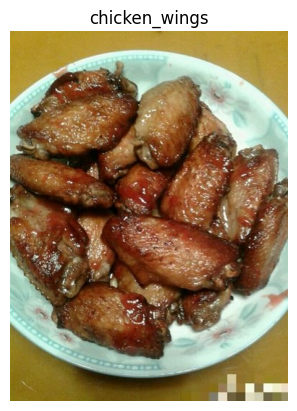

In [ ]:
# exploring the images and directories

class_names = sorted(os.listdir('10_food_classes_10_percent/train'))


random_class = np.random.choice(class_names)

random_image = np.random.choice(sorted(os.listdir('10_food_classes_10_percent/train' + '/' + random_class)))

full_path_of_image = '10_food_classes_10_percent/train' + '/' + random_class + '/' + random_image

# convert the image into numbers:
img_to_numbers = image.imread(full_path_of_image)

# show the image
plt.imshow(img_to_numbers)
plt.title(random_class)
plt.axis('off')

plt.show()

In [ ]:
# getting the train_dir and test_dir
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'


# train_data and test_data
train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         batch_size=32,
                                                         image_size=(224,224),
                                                         label_mode='int',
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        batch_size=32,
                                                        image_size=(224,224),
                                                        label_mode='int',
                                                        seed=42)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# see the images in train_data
for x_train,y_train in train_data:
  print(x_train.shape)
  print(y_train.shape)
  break


(32, 224, 224, 3)
(32,)


In [ ]:
y_train

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([9, 8, 0, 9, 0, 1, 1, 3, 9, 6, 4, 9, 2, 4, 0, 1, 6, 2, 1, 9, 2, 9,
       5, 7, 3, 6, 9, 5, 5, 0, 0, 3], dtype=int32)>

''

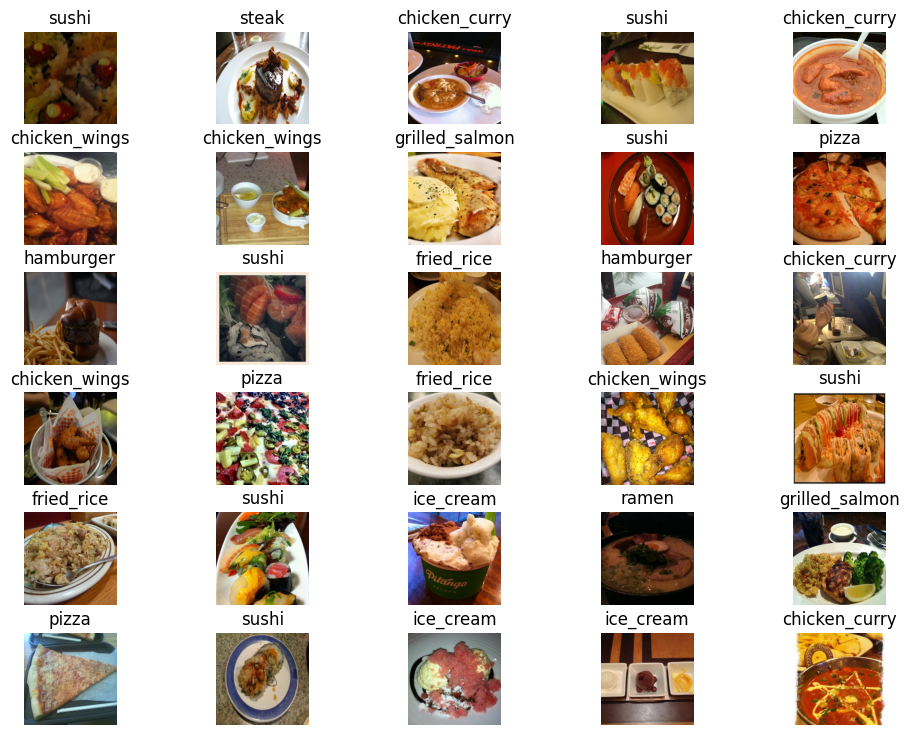

In [ ]:
plt.figure(figsize=(12,9))
plt.subplots_adjust(hspace=0.3)
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.imshow(x_train[i]/255.)
  plt.title(class_names[y_train[i]])
  plt.axis('off')
_

In [ ]:
# tensorboard callback

def tensorboard_callback(experiment_name):
  log_dir = 'tensorboard_models' + '/' + experiment_name + '/' + datetime.datetime.now(pytz.timezone('Asia/Calcutta')).strftime('%y%m%d-%H%M%S')

  tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

  return tensorboard

# creating our transfer learning model using functional API(as intuitive as pytorch)


# why include_top = False?
* because we don't want to take the base_model's input shape and output shape. for example in our case it is a efficient net model which has 1000 classes outputs but our model only requires 10 classes. so customize our own need we need to set the include_top = False.

# why not rescaling layer?
* all efficient net models are pretrained with rescaling factor so we don't need to include rescaling when we use it.
* resnet model needs rescaling when we create model using it.



In [ ]:
# setting random seed
tf.random.set_seed(42)

# create base_model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# setting the base_model to untrainable(we want to create just the feature extractor layer.)
base_model.trainable = False

# create the input layer
input_layer = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# passing the input_layer into the base_model
x = base_model(input_layer)

# passing these two layers into GlobalAveragePooling2D layer
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# passing all these layers into the output_layer
output_layer = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

# create the model
model0 = tf.keras.Model(input_layer,output_layer)

# compile the model
model0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# fit the model
history0 = model0.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      callbacks=tensorboard_callback('model0'))





24274472/24274472 [==============================] - 1s 0us/step
Epoch 1/5
24/24 [==============================] - 28s 511ms/step - loss: 1.9076 - accuracy: 0.3907 - val_loss: 1.3442 - val_accuracy: 0.7124
Epoch 2/5
24/24 [==============================] - 8s 340ms/step - loss: 1.1470 - accuracy: 0.7600 - val_loss: 0.9064 - val_accuracy: 0.8052
Epoch 3/5
24/24 [==============================] - 7s 283ms/step - loss: 0.8346 - accuracy: 0.8147 - val_loss: 0.7190 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 7s 273ms/step - loss: 0.6790 - accuracy: 0.8573 - val_loss: 0.6238 - val_accuracy: 0.8488
Epoch 5/5
24/24 [==============================] - 8s 305ms/step - loss: 0.5956 - accuracy: 0.8707 - val_loss: 0.5666 - val_accuracy: 0.8556


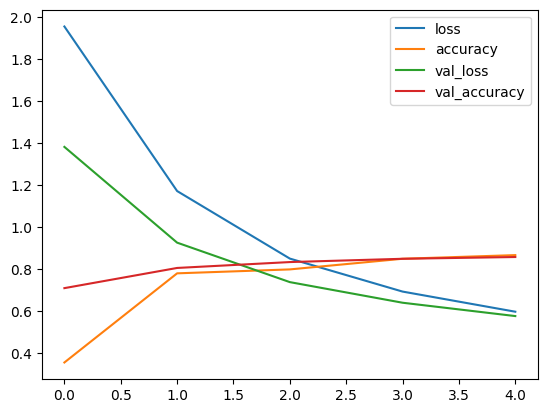

In [ ]:
pd.DataFrame(history0.history).plot();

In [ ]:
# print all the layers in our base_model
base_model.layers

# you see our rescaling here?

In [ ]:
# summary of our model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [ ]:
model0.summary()

# the model trained only the output_layer it seems from the graph below.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

# how are memories stored in the neural network?

# hopfield network:

$$ v_{j} (t+1) = \sum_{t=1}^{N} w_{ji}v_{i} \left(t\right) $$


# Memories in dynamical adaptive systems:
* connect all this things in your mind: mobius band, a rubber that when pressed gets to a compressed state but when the pressure is released it gets back to its original state, memories in brain.

* all the above mentioned things are related.

* The memory topology of adaptive systems preserve an original state that they get back to after the compression(new_memory formation) is released. In case of our brain, the compression can be new-memory formation. when we form a new memory the topology of the memory architecture twists, turns, gets squeezed, wobbles and throbs to accomodate the new incoming information, if the compression is strong enough, that is if the new_information formation takes enough time to etch itself onto the architecture the previously held memorites will have been deleted/modified and the new_information will have formed connections with all previously existing relevant information, just like the rubber or mobius band or any dynammic system for that matter.


# study more about hebbian learning:

* when a network has too many memories they merge to create a new non-existing memory which we call dreams.


# the effect of GlobaAveragePooling2D

* it reduces the dimension of the tensor keep only the outer dimensions.
* suppose our input_layer which is being passedinto the GlobalAveragePooling2D layer had the dimension of (1,224,224,3) then it would turn out to be (1,3).

In [ ]:
input_shape = (1, 4, 5, 3)
x = tf.random.normal(input_shape)
y = tf.keras.layers.GlobalAveragePooling2D()(x)
y

# it reduces the dimension of the tensor keep only the outer dimensions.

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.13519286, -0.32778087, -0.18581302]], dtype=float32)>

In [ ]:
# replicating GlobalAveragePooling2D layer


# it computes the mean of the tensor across the specified dimensions
tf.reduce_mean(x,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.13519286, -0.32778087, -0.18581302]], dtype=float32)>

In [ ]:
# better illustration of reduce_mean

a = np.random.randint(1,9,(3,3))
a = tf.constant(a,dtype=tf.float32)

a

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[2., 3., 4.],
       [6., 4., 1.],
       [3., 4., 2.]], dtype=float32)>

In [ ]:
tf.reduce_mean(a,axis=[1])

# this is how globalaveragepoolinglayer works too.

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.       , 3.6666667, 3.       ], dtype=float32)>

# day 198,day200,day 206

# part 2 of our bluprint:

*  create model1. use 1% of training data. here the difference with this model is we are doing data augmentation such as adjusting zoom range, shear range, horizontal flip etc. use the same feature_extractor_layer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import requests
import os
import zipfile
import pytz
import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as image
import pandas as pd

In [ ]:
# download and unzip the 1% data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

zip = zipfile.ZipFile('10_food_classes_1_percent.zip')
zip.extractall()
zip.close()

--2023-10-13 14:27:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 142.250.99.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   225MB/s    in 0.6s    

2023-10-13 14:27:56 (225 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# how many classes are we working with this time?

len(os.listdir('10_food_classes_1_percent/train'))

10

In [ ]:
# train and test data splitting.

train_dir = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=(224,224),
                                                         batch_size=32,
                                                         label_mode='int',
                                                         seed=42)


test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=(224,224),
                                                        batch_size=32,
                                                        label_mode='int',
                                                        seed=42)




Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# data augmentation:(this is a new method for doing data augmentation tensorflow 2.2 onwards)
# data augmentation avoid overfitting on training data.

'''the benefit of augmenting data this way versus using our previous technique: ImageDataGenerator() is, this
   technique makes use of GPU where as augmentation done with ImageDataGenerator() only uses CPU power which can
   prove slower with big data.

   another advantage is it automatically chooses to augment only the training data which we had to explicitly do
   previously '''



data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])



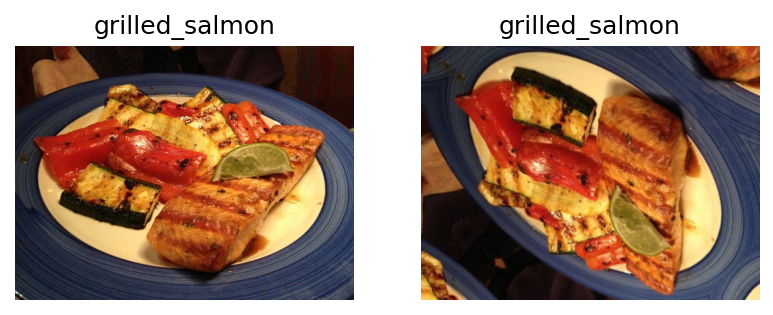

In [ ]:
# visualizing the images: augmented vs normal

dir = '10_food_classes_1_percent/train'
random_class = np.random.choice(os.listdir(dir))
random_image = np.random.choice(os.listdir(dir + '/' + random_class))
random_image_location = dir + '/' + random_class + '/' + random_image
img_to_numbers = image.imread(random_image_location)

# viewing the normal image
fig,ax = plt.subplots(1,2,dpi=150)

# normal image
ax[0].imshow(img_to_numbers)
ax[0].set_title(random_class)
ax[0].axis('off')

# augmented image
ax[1].imshow(data_augmentation(img_to_numbers)/255.)
ax[1].set_title(random_class)
ax[1].axis('off')

plt.show()


In [ ]:
def tensorboard_callback(model_name):
  log_dir = 'TensorBoard' + '/' + model_name +  '/' + datetime.datetime.now(pytz.timezone('Asia/Calcutta')).strftime('%y%m%d-%H%M%S')

  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

  return tensorboard_callback


In [ ]:
# create the model1 with frozen base_model layers (we want only feature extractor layer)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# freeze all of its layers from training
base_model.trainable = False

# create input layer
input_layer = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# run the data aumentation on input layer
x = data_augmentation(input_layer)

# connect the base_model to the augmented input_layer but don't train it
x = base_model(x,training=False)

# create global average pooling 2d layer
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)

# create the output layer
output_layer = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

# put all these layers into model1
model1 = tf.keras.Model(input_layer,output_layer)

# compiling the model
model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# fit the model
history1 = model1.fit(train_data,
           epochs=10,
           steps_per_epoch=len(train_data),
           validation_data=test_data,
           validation_steps=len(test_data),
           callbacks=tensorboard_callback('model1'))

24274472/24274472 [==============================] - 0s 0us/step
Epoch 1/10
3/3 [==============================] - 25s 4s/step - loss: 2.5034 - accuracy: 0.0571 - val_loss: 2.2919 - val_accuracy: 0.1472
Epoch 2/10
3/3 [==============================] - 8s 4s/step - loss: 2.2544 - accuracy: 0.1143 - val_loss: 2.1686 - val_accuracy: 0.2376
Epoch 3/10
3/3 [==============================] - 8s 4s/step - loss: 2.1051 - accuracy: 0.2714 - val_loss: 2.0617 - val_accuracy: 0.3056
Epoch 4/10
3/3 [==============================] - 9s 4s/step - loss: 1.9230 - accuracy: 0.4143 - val_loss: 1.9665 - val_accuracy: 0.3532
Epoch 5/10
3/3 [==============================] - 7s 3s/step - loss: 1.7656 - accuracy: 0.5429 - val_loss: 1.8838 - val_accuracy: 0.3868
Epoch 6/10
3/3 [==============================] - 11s 5s/step - loss: 1.6393 - accuracy: 0.6714 - val_loss: 1.8079 - val_accuracy: 0.4308
Epoch 7/10
3/3 [==============================] - 6s 3s/step - loss: 1.5479 - accuracy: 0.6429 - val_loss: 1.73

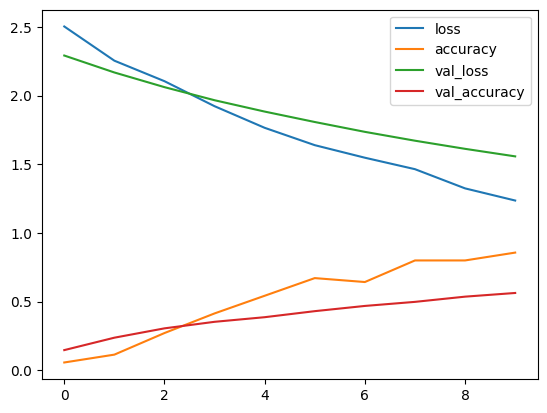

In [ ]:
pd.DataFrame(history1.history).plot();

# Goal: part 3 of blueprint

* build model2 with 10% of training data
* use data augmentation on inputs.
* use feature extractor layer only.
* fit the model to see the performance.

In [ ]:
# downloading the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-10-13 14:30:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   185MB/s    in 0.9s    

2023-10-13 14:30:28 (185 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# unzipping the files
zip = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip.extractall()
zip.close()

In [ ]:
# train test splitting in tensorflow style

train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=(224,224),
                                                         batch_size=32,
                                                         label_mode='int',
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=(224,224),
                                                        batch_size=32,
                                                        label_mode='int',
                                                        seed=42)



Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# data augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)]
)

In [ ]:
# creating the model2 with top layers frozen and untrainable
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# keeping the base_model untrainable
base_model.trainable = False

# creating input layers
input_layer = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# augmenting the input_layer
x = data_augmentation(input_layer)

# passing the augmented input_layer into the base_model and keeping it untrainable
x = base_model(x,training=False)

# passing the this layer into global average pooling 2d layer
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)

# passing this layer into the output layer
output_layer = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

# creating the model2
model2 = tf.keras.Model(input_layer,output_layer)

# compiling the model
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])


# model checkpointing

* if training your model takes a long time that you can't do that in one sitting then you can create a checkpoint for how much has so far been trained for continuing your training from there onwards lateron.

In [ ]:
file_path = 'checkpoint/model2'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                         save_weights_only=True,# save only the weights
                                                         save_best_only=True,# save just the best
                                                         save_freq='epoch', # save it in every epoch
                                                         verbose=1)


In [ ]:
# passing this model checkpoint callback instead of tensorboard into our model

tf.random.set_seed(42)
history2 = model2.fit(train_data,
           epochs=10,
           steps_per_epoch=len(train_data),
           validation_data=test_data,
           validation_steps=len(test_data),
           callbacks=checkpoint_callback)


Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 2.0013 - accuracy: 0.3347
Epoch 1: val_loss improved from inf to 1.46827, saving model to checkpoint/model2
24/24 [==============================] - 26s 532ms/step - loss: 2.0013 - accuracy: 0.3347 - val_loss: 1.4683 - val_accuracy: 0.6616
Epoch 2/10
23/24 [===========================>..] - ETA: 0s - loss: 1.4021 - accuracy: 0.6087
Epoch 2: val_loss improved from 1.46827 to 1.10558, saving model to checkpoint/model2
24/24 [==============================] - 9s 362ms/step - loss: 1.3986 - accuracy: 0.6067 - val_loss: 1.1056 - val_accuracy: 0.7304
Epoch 3/10
23/24 [===========================>..] - ETA: 0s - loss: 1.1295 - accuracy: 0.7215
Epoch 3: val_loss improved from 1.10558 to 0.87681, saving model to checkpoint/model2
24/24 [==============================] - 7s 292ms/step - loss: 1.1284 - accuracy: 0.7213 - val_loss: 0.8768 - val_accuracy: 0.7968
Epoch 4/10
23/24 [===========================>..] - ETA: 0s - loss: 0.

# using the weights of our model2

In [ ]:
original_performance = model2.evaluate(test_data)
original_performance

79/79 [==============================] - 7s 76ms/step - loss: 0.5117 - accuracy: 0.8536


[0.5116527080535889, 0.853600025177002]

In [ ]:
model2.load_weights(filepath=file_path)
loaded_performance = model2.evaluate(test_data)
loaded_performance

79/79 [==============================] - 7s 80ms/step - loss: 0.5117 - accuracy: 0.8536


[0.5116525292396545, 0.853600025177002]

In [ ]:
# check whether they are close to each other
np.isclose(np.array(original_performance),np.array(loaded_performance))

array([ True,  True])

# blueprint: goal 4
 create model3. use 10% of training data. use the same augmentation techniques. but this time fine-tune the neural layers instead of using feature extractor layer(top 10 layers unfrozen).



# Things to know before doing fine tuning:
* first few layers of the previous model are frozen and untrainable.
----------
* the other layers can learn the patterns of the new-dataset it is thrown at.
------------
* fine-tuning works best if feature extractor model is trained for a few epochs on large custom data and then some of the layers towards the output are unfrozen(made trainable) to let the model fine-tune its classification patterns.
----------------
* recompile the model with loss,optimizer,and metrics and fine-tuning is done.
----------------
* set the optimizer's learning rate 10 times smaller than usual i.e lr = 0.0001. the reasoning behind this is the base_model may be already at the ideal point (in our case giving out an accuracy of 0.85) so we want to move very slowly to further improve the model. Haste makes Waste in lot here.
----------------
* set initial_epoch when fitting the model for fine-tuning continuing from the previous training. i.e if the model was trained with feauture extractor layer for 10 times then when fine tuning the initial_epoch should be set to 10 beggining from the tenth epoch. you can set it with history2.epoch[-1].


# philosophy:
* having the memory of the past would truly help you evolve better!
---------
* having the memory of the previous patterns of similar kinds of materials would truly help you predict and classify better.

In [ ]:
# how many layers are there in the base_model?
base_model.layers

In [ ]:
# take the all the layers except the last 10 from base_model
for layer in base_model.layers[:-10]:
  print(layer)

In [ ]:
# taking the base_model layer from model2
model2.layers[2].layers

In [ ]:
# check which layers are trainable in model2 base_layers

for i, layer in enumerate(model2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
# check how many variables in model2 are trainable

len(model2.trainable_variables)

2

# let's fine-tune(make few layers untrainable and few layers trainable)

In [ ]:
# first all the layers in the base_model trainable
base_model.trainable = True

# keet only the last few layers in the base model trainable(lets say last 10 layers) and others are untrainable
for layer in base_model.layers[:-10]:
  layer.trainable = False


# recompiling the model2
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),# 10x smaller lr
               metrics=['accuracy'])

# lets check the number of layers in model 2 trainable now

In [ ]:
len(model2.trainable_variables)

# extra 10 trainable layers in model2 come from the base_model, now the model got few more layers to learn the pattern
# of the images

12

In [ ]:
# knowing the history 2 epoch
history2.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
# fitting and evaluating the model:
epoch_for_model2 = 10

fine_tuning_epochs= epoch_for_model2 + 5

model3_history = model2.fit(train_data,
                            epochs=fine_tuning_epochs,
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=len(test_data),
                            initial_epoch=history2.epoch[-1],
                            callbacks=[tensorboard_callback('model3'),checkpoint_callback])

Epoch 10/15
23/24 [===========================>..] - ETA: 0s - loss: 0.5579 - accuracy: 0.8641
Epoch 10: val_loss improved from 0.51165 to 0.49323, saving model to checkpoint/model2
24/24 [==============================] - 14s 540ms/step - loss: 0.5551 - accuracy: 0.8653 - val_loss: 0.4932 - val_accuracy: 0.8568
Epoch 11/15
23/24 [===========================>..] - ETA: 0s - loss: 0.5346 - accuracy: 0.8764
Epoch 11: val_loss improved from 0.49323 to 0.47932, saving model to checkpoint/model2
24/24 [==============================] - 7s 292ms/step - loss: 0.5283 - accuracy: 0.8787 - val_loss: 0.4793 - val_accuracy: 0.8588
Epoch 12/15
23/24 [===========================>..] - ETA: 0s - loss: 0.5147 - accuracy: 0.8723
Epoch 12: val_loss improved from 0.47932 to 0.47565, saving model to checkpoint/model2
24/24 [==============================] - 7s 303ms/step - loss: 0.5106 - accuracy: 0.8747 - val_loss: 0.4756 - val_accuracy: 0.8556
Epoch 13/15
23/24 [===========================>..] - ETA: 0s

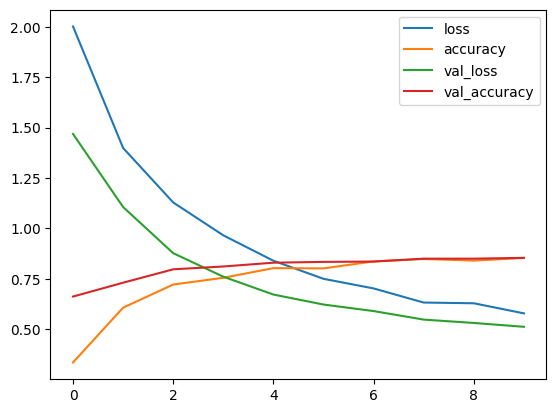

In [ ]:
# model3 is just model2 fine-tuned for another 5 epochs:

# seeing the difference between model2 without fine-tuning and with fine-tuning (which is model3)

pd.DataFrame(history2.history).plot();

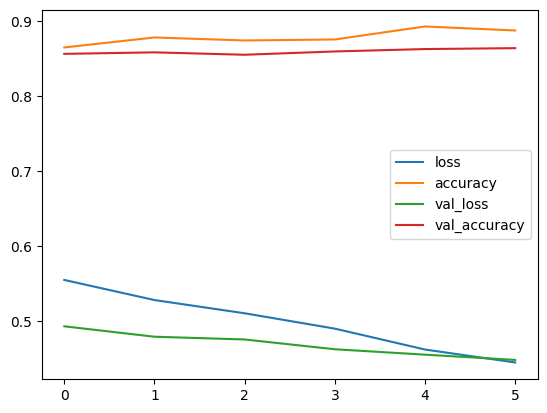

In [ ]:
pd.DataFrame(model3_history.history).plot();

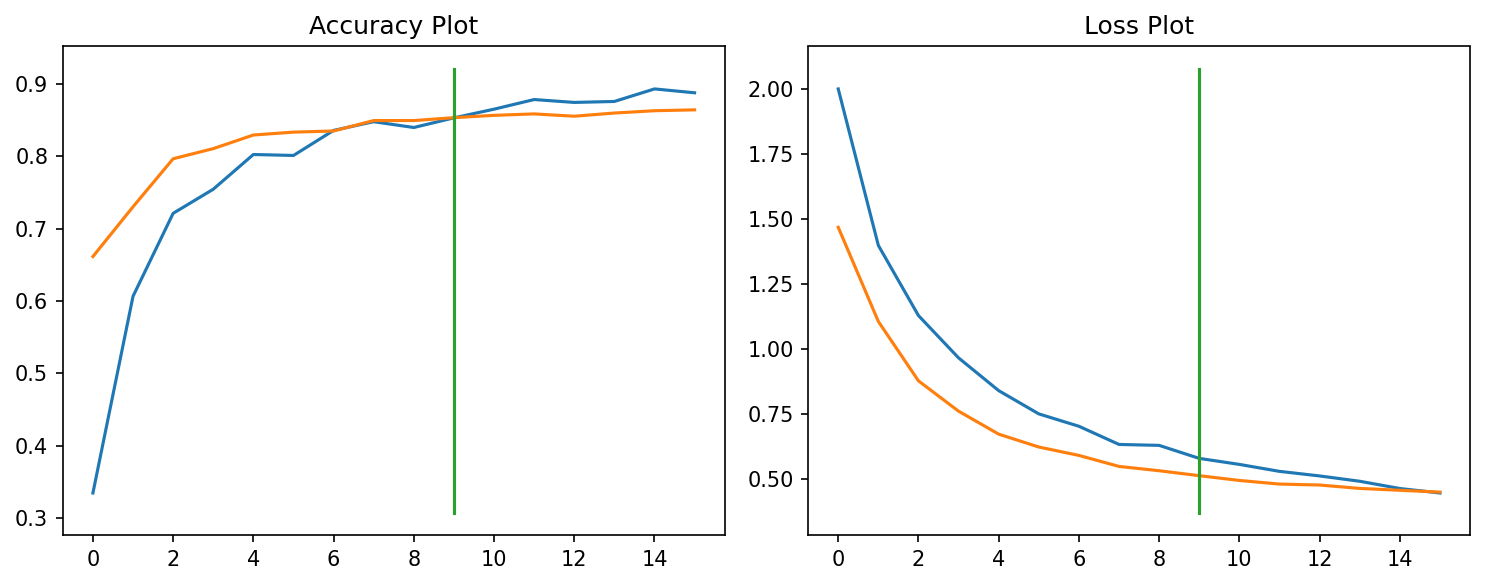

In [ ]:
total_acc = history2.history['accuracy'] + model3_history.history['accuracy']
total_val_acc = history2.history['val_accuracy'] + model3_history.history['val_accuracy']
total_loss = history2.history['loss'] + model3_history.history['loss']
total_val_loss = history2.history['val_loss'] + model3_history.history['val_loss']

plt.figure(dpi=150,figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(total_acc,label='Training Accuracy')
plt.plot(total_val_acc,label='Testing Accuracy')
plt.plot([9,9],plt.ylim(),label='start fine-tuning')
plt.title('Accuracy Plot')
plt.tight_layout()


plt.subplot(1,2,2)
plt.plot(total_loss,label='Training Loss')
plt.plot(total_val_loss,label='Testing Loss')
plt.plot([9,9],plt.ylim(),label='start fine-tuning')
plt.title('Loss Plot')
plt.tight_layout()

plt.show()


# day 206

# blueprint goal 4:
create model4

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import zipfile
import os
import datetime
import requests
import pathlib
import pytz

In [2]:
# getting and unzipping the data

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-10-16 13:16:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.207, 173.194.211.207, 173.194.212.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   103MB/s    in 5.0s    

2023-10-16 13:16:36 (98.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [3]:
zip = zipfile.ZipFile('10_food_classes_all_data.zip')
zip.extractall()
zip.close()

In [5]:
# data splitting and augmentation
train_dir = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=(224,224),
                                                         batch_size=32,
                                                         label_mode='int',
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=(224,224),
                                                        batch_size=32,
                                                        label_mode='int',
                                                        seed=42)

# data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [15]:
# creating the necessary callbacks

def TensorBoard(experiment_name):
  log_dir = 'tensorboard_callbacks' + '/' + experiment_name + '/' + datetime.datetime.now(pytz.timezone('Asia/Calcutta')).strftime('%y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

  return tensorboard_callback


def ModelCheckpoint(experiment_name):
  file_path = 'ModelCheckpoints/' + experiment_name

  mcp = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                            save_best_only=True,
                                            save_weights_only=True,
                                            save_freq='epoch')

  return mcp



In [18]:
# creating the feature extractor model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# making the base_model untrainable
base_model.trainable = False

# creating input layer
input_layer = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# augmenting the input layer
x = data_augmentation(input_layer)

# putting the augmented input layer into the base_model
x = base_model(x,training=False)

# inserting the above layer into GlobalAveragePooling2D layer
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)

# creating the output layer and inserting the above layers into it.
output_layer = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

# creating the model
model4 = tf.keras.Model(input_layer,output_layer)

# compiling the model
model4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# fit the model
initial_epochs =  5

history4 = model4.fit(train_data,
                      epochs=initial_epochs,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      callbacks=[TensorBoard('model4'),ModelCheckpoint('model4')])



Epoch 1/5
235/235 [==============================] - 45s 118ms/step - loss: 1.0833 - accuracy: 0.6848 - val_loss: 0.4805 - val_accuracy: 0.8676
Epoch 2/5
235/235 [==============================] - 24s 101ms/step - loss: 0.6875 - accuracy: 0.7901 - val_loss: 0.3819 - val_accuracy: 0.8880
Epoch 3/5
235/235 [==============================] - 26s 107ms/step - loss: 0.6082 - accuracy: 0.8119 - val_loss: 0.3438 - val_accuracy: 0.8956
Epoch 4/5
235/235 [==============================] - 23s 95ms/step - loss: 0.5696 - accuracy: 0.8172 - val_loss: 0.3244 - val_accuracy: 0.8972
Epoch 5/5
235/235 [==============================] - 25s 106ms/step - loss: 0.5421 - accuracy: 0.8260 - val_loss: 0.3113 - val_accuracy: 0.8980


# conclusion: model seems to under fit on the training data.

In [19]:
# finetuning the model

# keeping the all the layers in the base_model trainable
base_model.trainable = True

# freezing the early layers until the last 10 layers.
for layer in base_model.layers[:-10]:
  layer.trainable = False

# recompiling the model (having 10x less learning rate)
model4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=['accuracy'])

# fitting the model4
tf.random.set_seed(42)
fine_tuning_epochs = initial_epochs + 10
model4.fit(train_data,
           epochs=fine_tuning_epochs,
           steps_per_epoch=len(train_data),
           validation_data=test_data,
           validation_steps=len(test_data),
           initial_epoch = history4.epoch[-1],
           callbacks=[TensorBoard('model4'),ModelCheckpoint('model4')])

Epoch 5/15
235/235 [==============================] - 39s 110ms/step - loss: 0.4980 - accuracy: 0.8340 - val_loss: 0.2716 - val_accuracy: 0.9084
Epoch 6/15
235/235 [==============================] - 30s 123ms/step - loss: 0.4593 - accuracy: 0.8511 - val_loss: 0.2663 - val_accuracy: 0.9072
Epoch 7/15
235/235 [==============================] - 25s 104ms/step - loss: 0.4368 - accuracy: 0.8555 - val_loss: 0.2487 - val_accuracy: 0.9156
Epoch 8/15
235/235 [==============================] - 26s 110ms/step - loss: 0.3974 - accuracy: 0.8711 - val_loss: 0.2505 - val_accuracy: 0.9128
Epoch 9/15
235/235 [==============================] - 28s 118ms/step - loss: 0.3882 - accuracy: 0.8748 - val_loss: 0.2526 - val_accuracy: 0.9188
Epoch 10/15
235/235 [==============================] - 23s 97ms/step - loss: 0.3576 - accuracy: 0.8804 - val_loss: 0.2506 - val_accuracy: 0.9140
Epoch 11/15
235/235 [==============================] - 25s 102ms/step - loss: 0.3514 - accuracy: 0.8872 - val_loss: 0.2478 - val_a

# uploading the dev records to tensorboard

In [20]:
!tensorboard dev upload --logdir ./tensorboard_callbacks/ \
--name 'food vision model4 '\
--description 'it classifies food with over 90% accuracy trained on efficientnetv2b0'\
--one_shot

2023-10-16 15:11:15.084449: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorboard_callbacks/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   NXB-QFF-QHC



****************************************************************
****

In [21]:
# to see what experiments you have in the tensorboard

!tensorboard dev list

2023-10-16 15:24:09.971532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

****************************************************************
****************************************************************
****************************************************************

NOTICE - ACTION REQUIRED: TensorBoard.dev is shutting down.

Please export your experiments by Dec 31, 2023.

See the FAQ at https://tensorboard.dev.

****************************************************************
****************************************************************
****************************************************************

https://tensorboard.dev/experiment/33ka6upTRtGTELrkxbRAtA/
	Name                 food vision model4 
	Description          it classifies food with over 90% accuracy trained on efficientnetv2b0
	Id                   33ka6upTRtGTELrkxbRAtA
	Created              2023-10-16 15:14:00 (10 minutes ago)
	Updated              2023-10-16 15